<a href="https://colab.research.google.com/github/rahulrj/moss-small-lm-experiments/blob/main/moss_small_lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir
import numpy as np
print(np.__version__)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 128.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
1.26.4


In [ ]:
!pip install -q transformers datasets evaluate
!pip install -q accelerate

In [ ]:
# Experiment Overview: Few-Shot Prompting Across Tasks and Model Scales
# This experiment evaluates the few-shot generalization capabilities of three small-scale language models—distilgpt2, gpt2, and gpt2-medium—on four simple NLP tasks:

# Sentiment Classification
# Arithmetic Addition
# Grammar Correction
# Pluralization

# For each model and task, we test performance from 0-shot to 5-shot prompting, where k in-context examples are shown before the test query.

# How the Experiment Works
# Prompt Construction:
# For each task, a prompt is created by concatenating k few-shot examples and one test input.

# Model Generation:
# The prompt is passed to the model (using greedy decoding), and the output is truncated at [END] or a newline.

# Evaluation:
# The model's prediction is compared to the ground truth. Accuracy is computed for each (model, task, shot count) combination.

# Scaling Analysis:
# Accuracy scores are recorded across different shot counts and model sizes to understand how performance scales with model capacity and available context.

# Outcome
# The final output is a DataFrame showing the accuracy of each model on each task at various shot counts. This helps assess:
# How few-shot learning improves with more examples.
# Whether larger models generalize better with limited supervision.
# Which tasks are easier or harder for small LMs under few-shot settings.








from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Define 4 few-shot prompting tasks
tasks = {
    "sentiment": {
        "examples": [
            ("Review: I loved this movie.\nLabel:", "Positive"),
            ("Review: This was terrible.\nLabel:", "Negative"),
            ("Review: A truly wonderful experience.\nLabel:", "Positive"),
            ("Review: I couldn’t stand it.\nLabel:", "Negative"),
            ("Review: Absolutely fantastic!\nLabel:", "Positive"),
            ("Review: It was a complete waste of time.\nLabel:", "Negative")
        ],
        "tests": [
            ("Review: The food was amazing!\nLabel:", "Positive"),
            ("Review: I hated every minute.\nLabel:", "Negative"),
            ("Review: It was okay, not great.\nLabel:", "Negative"),
            ("Review: Brilliant work!\nLabel:", "Positive"),
            ("Review: The plot was so boring.\nLabel:", "Negative"),
            ("Review: I loved the cinematography.\nLabel:", "Positive"),
            ("Review: I’d never recommend this.\nLabel:", "Negative"),
            ("Review: It made me smile.\nLabel:", "Positive"),
            ("Review: Too long and unoriginal.\nLabel:", "Negative"),
            ("Review: A heartwarming story.\nLabel:", "Positive")
        ]
    },
    "addition": {
        "examples": [
            ("2 + 2 =", "4"),
            ("3 + 5 =", "8"),
            ("10 + 7 =", "17"),
            ("6 + 9 =", "15"),
            ("4 + 11 =", "15"),
            ("8 + 6 =", "14")
        ],
        "tests": [
            ("4 + 6 =", "10"),
            ("12 + 8 =", "20"),
            ("9 + 3 =", "12"),
            ("15 + 4 =", "19"),
            ("7 + 5 =", "12"),
            ("1 + 9 =", "10"),
            ("6 + 7 =", "13"),
            ("5 + 8 =", "13"),
            ("2 + 6 =", "8"),
            ("13 + 6 =", "19")
        ]
    },
    "grammar": {
        "examples": [
            ("Incorrect: He go school.\nCorrect:", "He goes to school."),
            ("Incorrect: I has a book.\nCorrect:", "I have a book."),
            ("Incorrect: She like apples.\nCorrect:", "She likes apples."),
            ("Incorrect: They is late.\nCorrect:", "They are late."),
            ("Incorrect: We goes home.\nCorrect:", "We go home."),
            ("Incorrect: It don't work.\nCorrect:", "It doesn't work.")
        ],
        "tests": [
            ("Incorrect: He have a car.\nCorrect:", "He has a car."),
            ("Incorrect: I going home.\nCorrect:", "I am going home."),
            ("Incorrect: She are tired.\nCorrect:", "She is tired."),
            ("Incorrect: They has arrived.\nCorrect:", "They have arrived."),
            ("Incorrect: We is happy.\nCorrect:", "We are happy."),
            ("Incorrect: It not raining.\nCorrect:", "It is not raining."),
            ("Incorrect: He do his work.\nCorrect:", "He does his work."),
            ("Incorrect: They goes school.\nCorrect:", "They go to school."),
            ("Incorrect: I has homework.\nCorrect:", "I have homework."),
            ("Incorrect: She like to dance.\nCorrect:", "She likes to dance.")
        ]
    },
    "plural": {
        "examples": [
            ("Singular: cat\nPlural:", "cats"),
            ("Singular: bus\nPlural:", "buses"),
            ("Singular: fox\nPlural:", "foxes"),
            ("Singular: berry\nPlural:", "berries"),
            ("Singular: hero\nPlural:", "heroes"),
            ("Singular: baby\nPlural:", "babies")
        ],
        "tests": [
            ("Singular: knife\nPlural:", "knives"),
            ("Singular: leaf\nPlural:", "leaves"),
            ("Singular: box\nPlural:", "boxes"),
            ("Singular: wolf\nPlural:", "wolves"),
            ("Singular: tomato\nPlural:", "tomatoes"),
            ("Singular: city\nPlural:", "cities"),
            ("Singular: wish\nPlural:", "wishes"),
            ("Singular: dish\nPlural:", "dishes"),
            ("Singular: man\nPlural:", "men"),
            ("Singular: woman\nPlural:", "women")
        ]
    }
}


def build_prompt(task_name: str, num_shots: int = 2) -> str:
    """
    Build a prompt for a given task using `num_shots` in-context examples.
    """
    assert task_name in tasks, "Task not found."
    examples = tasks[task_name]["examples"][:num_shots]
    test = tasks[task_name]["test"]

    prompt = "\n".join([f"{inp} {out} [END]" for inp, out in examples])
    prompt += "\n" + test
    return prompt


def generate_output(prompt: str, max_new_tokens: int = 30) -> str:
    """
    Generate clean output and stop at [END] or newline.
    """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True)

    # Extract up to [END] or newline
    for stop_token in ['[END]', '\n']:
        if stop_token in generated:
            generated = generated.split(stop_token)[0]
            break

    return generated.strip()



# Define model variants
MODEL_VARIANTS = {
    "distilgpt2": "distilgpt2",         # 82M params
    "gpt2": "gpt2",                     # 124M params
    "gpt2-medium": "gpt2-medium",       # 355M params
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_model_and_tokenizer(model_name):
    print(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.to(device)
    model.eval()
    return tokenizer, model


def generate_output(prompt: str, tokenizer, model, max_new_tokens: int = 30):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    output = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True)
    return output.strip().split('[END]')[0].strip()




def evaluate_task(task_name, num_shots, tokenizer, model):
    correct = 0
    total = 0

    for test_input, expected in tasks[task_name]["tests"]:
        tasks[task_name]["test"] = test_input
        prompt = build_prompt(task_name, num_shots)
        output = generate_output(prompt, tokenizer, model)

        is_correct = output.strip().lower() == expected.strip().lower()
        correct += int(is_correct)
        total += 1

    return correct / total


scaling_results = []


import sys
print("torchvision" in sys.modules)
print(sys.modules.get("torchvision"))
for model_key in MODEL_VARIANTS:
    tokenizer, model = load_model_and_tokenizer(MODEL_VARIANTS[model_key])

    for task_name in tasks.keys():
        for shots in range(0, 6):  # 0-shot to 3-shot
            acc = evaluate_task(task_name, shots, tokenizer, model)
            scaling_results.append({
                "Model": model_key,
                "Task": task_name,
                "Shots": shots,
                "Accuracy": round(acc, 2)
            })


import pandas as pd

df_scaling = pd.DataFrame(scaling_results)
display(df_scaling)


False
None
Loading model: distilgpt2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Loading model: gpt2


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loading model: gpt2-medium


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

,Model,Task,Shots,Accuracy
0,distilgpt2,sentiment,0,0.0
1,distilgpt2,sentiment,1,0.5
2,distilgpt2,sentiment,2,0.5
3,distilgpt2,sentiment,3,0.5
4,distilgpt2,sentiment,4,0.5
...,...,...,...,...
67,gpt2-medium,plural,1,0.9
68,gpt2-medium,plural,2,1.0
69,gpt2-medium,plural,3,1.0
70,gpt2-medium,plural,4,1.0


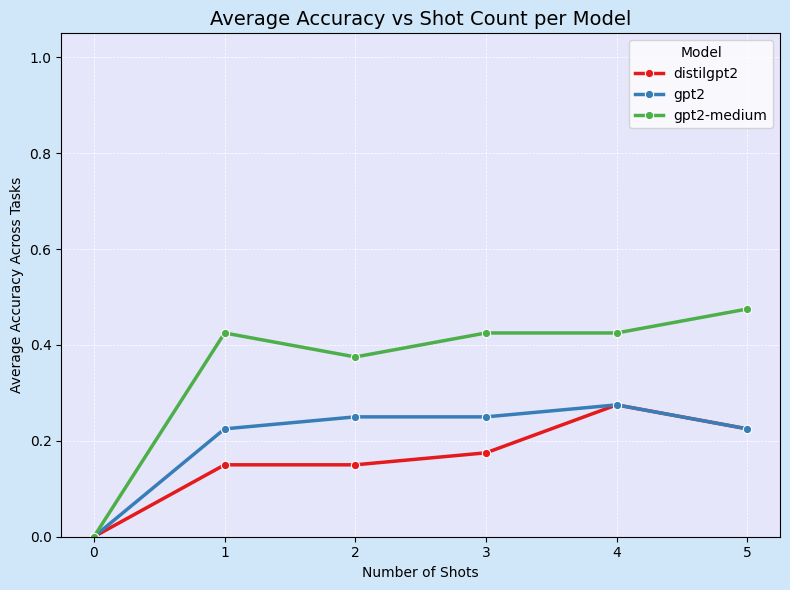

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by model and shot count, average over tasks
df_model_avg = df_scaling.groupby(["Model", "Shots"]).agg({"Accuracy": "mean"}).reset_index()

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Set colorful backgrounds
fig.patch.set_facecolor('#d0e7f9')  # Light blue figure background
ax.set_facecolor('#e6e6fa')         # Lighter blue for axes

# Define a bright custom color palette
palette = sns.color_palette(["#e41a1c", "#377eb8", "#4daf4a"])  # Red, blue, green

# Plot
sns.lineplot(
    data=df_model_avg,
    x="Shots",
    y="Accuracy",
    hue="Model",
    palette=palette,
    marker="o",
    linewidth=2.5,
    ax=ax
)

# Style tweaks
ax.set_title("Average Accuracy vs Shot Count per Model", fontsize=14, color="black")
ax.set_xlabel("Number of Shots", color="black")
ax.set_ylabel("Average Accuracy Across Tasks", color="black")
ax.tick_params(colors="black")
ax.set_ylim(0, 1.05)
ax.set_xticks(range(df_model_avg["Shots"].min(), df_model_avg["Shots"].max() + 1))
ax.grid(True, linestyle="--", linewidth=0.5, color="white")
ax.legend(title="Model")

plt.tight_layout()
plt.show()


Loading model: distilgpt2
Loading model: gpt2
Loading model: gpt2-medium


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b01983f7b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


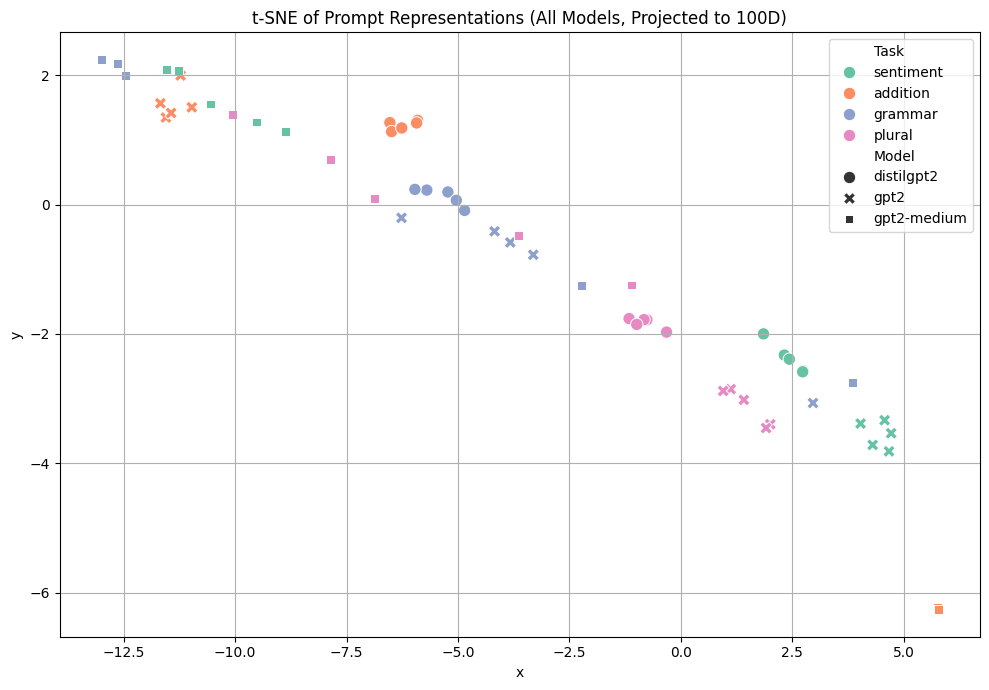

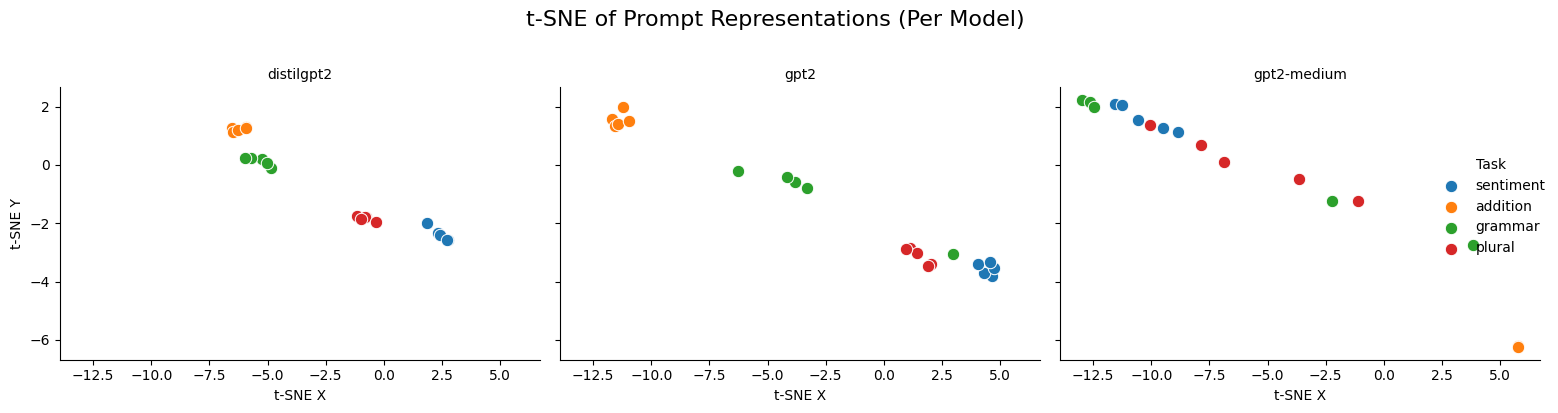

In [ ]:

# Prompt Embeddings:
# For each (model, task) pair, we generate few-shot prompts and extract the final hidden state (last token embedding) from the final layer of the model.

# Dimensionality Reduction:
# First, PCA reduces the high-dimensional embeddings (e.g., 768D/1024D) to 10D to remove noise and speed up t-SNE.
# Then, t-SNE maps these 10D vectors to 2D for visualization.

# Plotting:
# A combined scatter plot shows all model embeddings, colored by task and styled by model.
# A FacetGrid breaks down the t-SNE plots per model for clearer comparison.

# What It Shows
# Task Clustering: Do different tasks result in separable representations?
# Model Trends: Are larger models better at task separation in embedding space?
# Prompt Understanding: Do similar tasks cluster more tightly?

# This visualization helps understand how internal representations vary by model size and task type, offering insights into prompt generalization behavior.

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_last_token_hidden(prompt: str, tokenizer, model):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states[-1]  # final layer
    final_vec = hidden_states[0, -1, :].cpu().numpy()
    return final_vec


from sklearn.decomposition import PCA


vecs_all = []
task_labels = []
model_labels = []

for model_key in MODEL_VARIANTS:
    tokenizer, model = load_model_and_tokenizer(MODEL_VARIANTS[model_key])

    model_vecs = []
    model_tasks = []

    for task_name in tasks:
        for test_input, expected in tasks[task_name]["tests"][:5]:
            tasks[task_name]["test"] = test_input
            prompt = build_prompt(task_name, num_shots=3)
            vec = get_last_token_hidden(prompt, tokenizer, model)
            model_vecs.append(vec)
            model_tasks.append(task_name)

    model_vecs = np.stack(model_vecs)

    # Project to common size (e.g., 100D)
    pca = PCA(n_components=10, random_state=42)
    vecs_100d = pca.fit_transform(model_vecs)

    # Append with task + model labels
    vecs_all.extend(vecs_100d)
    task_labels.extend(model_tasks)
    model_labels.extend([model_key] * len(model_tasks))



# Convert to array
vecs_all = np.stack(vecs_all)

# t-SNE projection
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=15)
vecs_tsne = tsne.fit_transform(vecs_all)

# Plotting
df_tsne = pd.DataFrame(vecs_tsne, columns=["x", "y"])
df_tsne["Model"] = model_labels
df_tsne["Task"] = task_labels

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="Task", style="Model", palette="Set2", s=80)
plt.title("t-SNE of Prompt Representations (All Models, Projected to 100D)")
plt.grid(True)
plt.tight_layout()
plt.show()



import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_tsne has columns: x, y, Model, Task
g = sns.FacetGrid(df_tsne, col="Model", hue="Task", col_wrap=3, height=4, aspect=1.2)
g.map_dataframe(sns.scatterplot, x="x", y="y", s=80)

g.add_legend(title="Task")
g.set_titles("{col_name}")
g.fig.suptitle("t-SNE of Prompt Representations (Per Model)", fontsize=16, y=1.02)
g.set_axis_labels("t-SNE X", "t-SNE Y")
plt.tight_layout()
plt.show()



In [ ]:
# Step 1: Download the Parquet IMDb training data from Hugging Face manually
!wget https://huggingface.co/datasets/stanfordnlp/imdb/resolve/main/plain_text/train-00000-of-00001.parquet


--2025-05-23 05:20:02--  https://huggingface.co/datasets/stanfordnlp/imdb/resolve/main/plain_text/train-00000-of-00001.parquet
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.97, 13.35.202.34, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/datasets/imdb/db47d16b5c297cc0dd625e519c81319c24c9149e70e8496de5475f6fa928342c?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27train-00000-of-00001.parquet%3B+filename%3D%22train-00000-of-00001.parquet%22%3B&Expires=1747981203&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0Nzk4MTIwM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kYXRhc2V0cy9pbWRiL2RiNDdkMTZiNWMyOTdjYzBkZDYyNWU1MTljODEzMTljMjRjOTE0OWU3MGU4NDk2ZGU1NDc1ZjZmYTkyODM0MmM%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=Cpjhy90aTU%7Eu6XsTiZDTms8Wf984p5K-D4UGx1ABPe043eENVRL4Kg1Mtpp5x

In [ ]:
!pip install "protobuf==5.29.1" --force-reinstall --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 71.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4


In [ ]:



#  Experiment: Few-Shot Prompting vs Fine-Tuning for Sentiment Classification
# This experiment compares two approaches to solving a binary sentiment classification task using Hugging Face models:

# 1. Few-Shot Prompting
# Uses a text-generation pipeline (e.g., gpt2, distilgpt2) with k in-context examples (default: 4).

# For each test example, it constructs a prompt with k labeled examples + one unlabeled review.

# The model's generated output is parsed to extract the predicted sentiment.

# Accuracy is calculated by comparing predictions to ground-truth labels.

# 2. Fine-Tuning
# Loads a pre-trained transformer model (e.g., bert-base-uncased, gpt2) and adapts it for sequence classification with 2 labels.

# The dataset is tokenized, split, and mapped using Hugging Face Trainer.

# The model is fine-tuned for 3 epochs, and performance is evaluated using accuracy on the test set.

# 🔍 Purpose
# To evaluate:

# How well few-shot prompting performs compared to full model fine-tuning.

# The trade-off between inference-time flexibility (prompting) and training-time customization (fine-tuning).

# How different models behave under low-data or quick adaptation scenarios.




from datasets import load_dataset
import re

import transformers
transformers.logging.set_verbosity_error()

import os
os.environ["HF_DATASETS_CACHE"] = "./.cache"


# Step 2: Load using pandas
import pandas as pd

df = pd.read_parquet("train-00000-of-00001.parquet")

# Optional: Subsample to 1000 examples for quicker testing
df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Step 3: Create train/test splits
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = {"train": train_dataset, "test": test_dataset}




from transformers import pipeline

def few_shot_prompting(model_name, k=4):
    clf = pipeline("text-generation", model=model_name)
    shots = dataset['train'].select(range(k))
    prompt_examples = "\n".join(
        [f"Review: {ex['text'][:200]}\nSentiment: {'positive' if ex['label'] else 'negative'}" for ex in shots]
    )

    correct = 0
    counter=0
    total = len(dataset['test'])
    for ex in dataset['test']:
        test_prompt = f"{prompt_examples}\nReview: {ex['text'][:200]}\nSentiment:"
        output = clf(test_prompt, max_new_tokens=10)[0]['generated_text'].lower()
        matches = re.findall(r"(sentiment)[:\s]*([a-z]+)", output)
        pred = matches[-1][1] if matches else "unknown"


        if pred in ["positive", "good"] and ex['label'] == 1:
            correct += 1
        elif pred in ["negative", "bad"] and ex['label'] == 0:
            correct += 1

    accuracy = correct / total
    return accuracy



from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)

def fine_tune(model_name):
    global tokenizer  # So it's accessible inside `tokenize()`

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # ✅ Add pad_token if missing (GPT-2, distilgpt2)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    model.config.pad_token_id = tokenizer.pad_token_id

    # Tokenize each split separately
    tokenized = {
        "train": dataset["train"].map(tokenize, batched=True),
        "test": dataset["test"].map(tokenize, batched=True),
    }

    # Rename label column for Trainer compatibility
    for split in ["train", "test"]:
        tokenized[split] = tokenized[split].rename_column("label", "labels")
        tokenized[split].set_format("torch", columns=["input_ids", "attention_mask", "labels"])


    args = TrainingArguments(
        output_dir=f"./results/{model_name}",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        logging_steps=10
    )





    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["test"],
        compute_metrics=lambda p: accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)
    )

    trainer.train()

    save_path = f"./{model_name}-finetuned"
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)

    eval_results = trainer.evaluate()
    return eval_results["eval_accuracy"]



Running prompting for distilgpt2...
Running fine-tuning for distilgpt2...


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'loss': 0.7566, 'grad_norm': 73.0496597290039, 'learning_rate': 4.9250000000000004e-05, 'epoch': 0.05}
{'loss': 0.6922, 'grad_norm': 7.65831995010376, 'learning_rate': 4.8416666666666673e-05, 'epoch': 0.1}
{'loss': 0.6282, 'grad_norm': 14.760181427001953, 'learning_rate': 4.7583333333333336e-05, 'epoch': 0.15}
{'loss': 0.6989, 'grad_norm': 41.718082427978516, 'learning_rate': 4.6750000000000005e-05, 'epoch': 0.2}
{'loss': 0.5938, 'grad_norm': 46.654170989990234, 'learning_rate': 4.591666666666667e-05, 'epoch': 0.25}
{'loss': 0.5756, 'grad_norm': 19.94700050354004, 'learning_rate': 4.5083333333333336e-05, 'epoch': 0.3}
{'loss': 0.602, 'grad_norm': 34.48429870605469, 'learning_rate': 4.4250000000000005e-05, 'epoch': 0.35}
{'loss': 0.5136, 'grad_norm': 49.99296569824219, 'learning_rate': 4.341666666666667e-05, 'epoch': 0.4}
{'loss': 0.7625, 'grad_norm': 89.95187377929688, 'learning_rate': 4.2583333333333336e-05, 'epoch': 0.45}
{'loss': 0.9384, 'grad_norm': 25.01004409790039, 'learning_ra

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'loss': 1.2563, 'grad_norm': 70.14381408691406, 'learning_rate': 4.9250000000000004e-05, 'epoch': 0.05}
{'loss': 0.9877, 'grad_norm': 13.19677448272705, 'learning_rate': 4.8416666666666673e-05, 'epoch': 0.1}
{'loss': 0.8507, 'grad_norm': 93.05924987792969, 'learning_rate': 4.7583333333333336e-05, 'epoch': 0.15}
{'loss': 0.9094, 'grad_norm': 38.12179946899414, 'learning_rate': 4.6750000000000005e-05, 'epoch': 0.2}
{'loss': 0.9185, 'grad_norm': 52.14725112915039, 'learning_rate': 4.591666666666667e-05, 'epoch': 0.25}
{'loss': 0.8693, 'grad_norm': 31.13015365600586, 'learning_rate': 4.5083333333333336e-05, 'epoch': 0.3}
{'loss': 0.7515, 'grad_norm': 35.250396728515625, 'learning_rate': 4.4250000000000005e-05, 'epoch': 0.35}
{'loss': 0.8111, 'grad_norm': 25.25587272644043, 'learning_rate': 4.341666666666667e-05, 'epoch': 0.4}
{'loss': 0.7858, 'grad_norm': 23.083513259887695, 'learning_rate': 4.2583333333333336e-05, 'epoch': 0.45}
{'loss': 0.5858, 'grad_norm': 27.00334930419922, 'learning_

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'loss': 2.5437, 'grad_norm': 51.35508728027344, 'learning_rate': 4.9250000000000004e-05, 'epoch': 0.05}
{'loss': 1.2582, 'grad_norm': 7.016146183013916, 'learning_rate': 4.8416666666666673e-05, 'epoch': 0.1}
{'loss': 1.5267, 'grad_norm': 31.34195327758789, 'learning_rate': 4.7583333333333336e-05, 'epoch': 0.15}
{'loss': 0.6871, 'grad_norm': 28.239307403564453, 'learning_rate': 4.6750000000000005e-05, 'epoch': 0.2}
{'loss': 1.181, 'grad_norm': 33.95439529418945, 'learning_rate': 4.591666666666667e-05, 'epoch': 0.25}
{'loss': 0.738, 'grad_norm': 7.795920372009277, 'learning_rate': 4.5083333333333336e-05, 'epoch': 0.3}
{'loss': 0.5825, 'grad_norm': 42.1117057800293, 'learning_rate': 4.4250000000000005e-05, 'epoch': 0.35}
{'loss': 0.6352, 'grad_norm': 2.6075098514556885, 'learning_rate': 4.341666666666667e-05, 'epoch': 0.4}
{'loss': 0.1972, 'grad_norm': 0.11935286968946457, 'learning_rate': 4.2583333333333336e-05, 'epoch': 0.45}
{'loss': 0.9546, 'grad_norm': 202.17054748535156, 'learning_

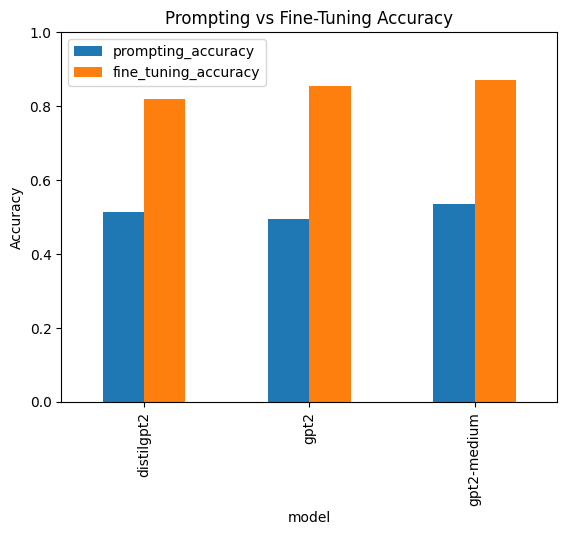

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


models = ["distilgpt2", "gpt2", "gpt2-medium"]
# models = ["distilgpt2"]

results = []

for model in models:
    print(f"Running prompting for {model}...")
    acc_prompt = few_shot_prompting(model)

    print(f"Running fine-tuning for {model}...")
    acc_finetune = fine_tune(model)

    results.append({
        "model": model,
        "prompting_accuracy": acc_prompt,
        "fine_tuning_accuracy": acc_finetune
    })

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
print(df)

df.plot(x="model", y=["prompting_accuracy", "fine_tuning_accuracy"], kind="bar")
plt.title("Prompting vs Fine-Tuning Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()




Running standard prompting for distilgpt2...
Correct: 107
Total: 200
Running qa prompting for distilgpt2...
Correct: 92
Total: 200
Running goodbad prompting for distilgpt2...
Correct: 97
Total: 200
Running standard prompting for gpt2...
Correct: 99
Total: 200
Running qa prompting for gpt2...
Correct: 93
Total: 200
Running goodbad prompting for gpt2...
Correct: 94
Total: 200
Running standard prompting for gpt2-medium...
Correct: 115
Total: 200
Running qa prompting for gpt2-medium...
Correct: 91
Total: 200
Running goodbad prompting for gpt2-medium...
Correct: 78
Total: 200
         model prompt_type  accuracy
0   distilgpt2    standard     0.535
1   distilgpt2          qa     0.460
2   distilgpt2     goodbad     0.485
3         gpt2    standard     0.495
4         gpt2          qa     0.465
5         gpt2     goodbad     0.470
6  gpt2-medium    standard     0.575
7  gpt2-medium          qa     0.455
8  gpt2-medium     goodbad     0.390


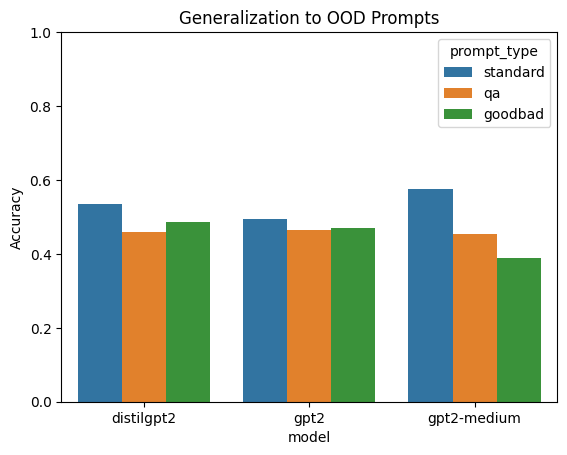

In [ ]:
# Experiment: OOD Prompt Generalization
# This experiment tests how well few-shot language models (distilgpt2, gpt2, gpt2-medium) generalize when the prompt
# format is changed at test time. We compare three prompt types:

# Standard: Review: ... Sentiment:

# QA-style: Question: What is the sentiment...? Answer:

# Good/Bad labels: Review: ... Label: good/bad

# We measure accuracy for each prompt type and model to assess robustness to prompt variation. Results are visualized in a bar plot.

import re


def format_test_prompt(text, prompt_type="standard"):
    if prompt_type == "standard":
        return f"Review: {text}\nSentiment:"
    elif prompt_type == "qa":
        return f'Question: What is the sentiment of this review?\n"{text}"\nAnswer:'
    elif prompt_type == "goodbad":
        return f"Review: {text}\nLabel:"



def format_prompt(text, label, prompt_type="standard"):
    if prompt_type == "standard":
        return f"Review: {text}\nSentiment: {'positive' if label else 'negative'}"
    elif prompt_type == "qa":
        return f'Question: What is the sentiment of this review?\n"{text}"\nAnswer: {"positive" if label else "negative"}'
    elif prompt_type == "goodbad":
        return f"Review: {text}\nLabel: {'good' if label else 'bad'}"
    else:
        raise ValueError(f"Unsupported prompt_type: {prompt_type}")



def few_shot_prompting(model_name, k=4, prompt_type="standard"):
    from transformers import pipeline, AutoTokenizer

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    pipe = pipeline("text-generation", model=model_name, tokenizer=tokenizer)

    # Use k few-shot examples from training set
    shots = dataset["train"].select(range(k))
    prompt_examples = "\n\n".join([
        format_prompt(ex["text"][:300], ex["label"], prompt_type)
        for ex in shots
    ])

    correct = 0
    total = len(dataset["test"])

    for i, ex in enumerate(dataset["test"]):
        label = ex["label"]
        test_prompt = f"{prompt_examples}\n\n{format_test_prompt(ex['text'][:300], prompt_type)}"
        output = pipe(test_prompt, max_new_tokens=5)[0]["generated_text"].lower()

        # Extract the LAST match of "label:", "sentiment:", or "answer:"
        matches = re.findall(r"(label|sentiment|answer)[:\s]*([a-z]+)", output)
        pred = matches[-1][1] if matches else "unknown"

        # Controlled print every 50th example
        # if i ==15:
        #     print(f"\nModel: {model_name} | Prompt: {prompt_type}")
        #     print(f"Sample #{i}")
        #     #print(f"Review: {ex['text'][:300]}")  # Limit to 300 characters
        #     print("Test")
        #     print(test_prompt)
        #     print("\n")
        #     print("Output")
        #     print(output)
        #     print("label")
        #     print(label)

        #     print(f"Prediction: {pred} | True: {'positive' if label else 'negative'}")
        #     break


        # Accuracy logic
        if pred in ["positive", "good"] and label == 1:
            correct += 1
        elif pred in ["negative", "bad"] and label == 0:
            correct += 1



    print("Correct:", correct)
    print("Total:", total)
    return correct / total




models = ["distilgpt2", "gpt2", "gpt2-medium"]
prompt_types = ["standard", "qa", "goodbad"]
# models = ["distilgpt2"]
# prompt_types = ["goodbad"]
results = []

for model in models:
    for prompt_type in prompt_types:
        print(f"Running {prompt_type} prompting for {model}...")
        acc = few_shot_prompting(model, prompt_type=prompt_type)
        results.append({
            "model": model,
            "prompt_type": prompt_type,
            "accuracy": acc
        })


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
print(df)

sns.barplot(data=df, x="model", y="accuracy", hue="prompt_type")
plt.title("Generalization to OOD Prompts")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


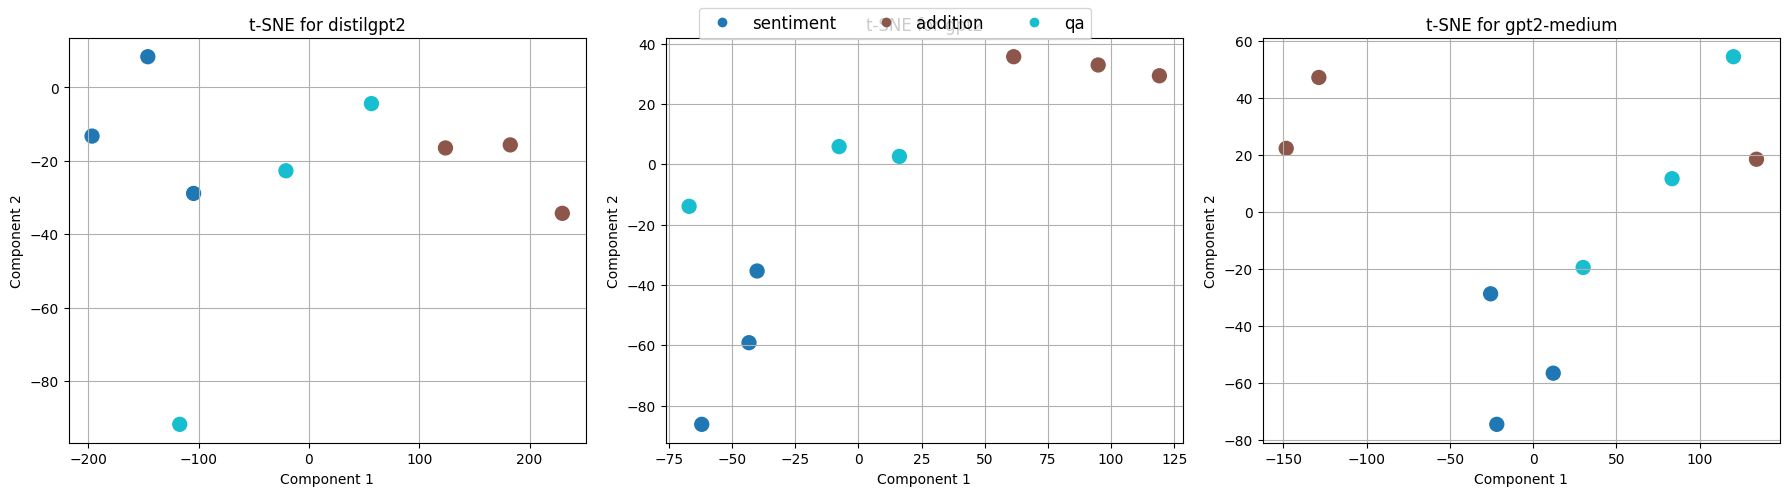

,Model,Average Probe Accuracy
0,distilgpt2,0.83
1,gpt2,0.80
2,gpt2-medium,0.60


In [ ]:

#  Experiment: Probing Task Representations in GPT Models
# This experiment evaluates how well different GPT models (distilgpt2, gpt2, gpt2-medium) encode task information internally.

# Tasks: Sentiment classification, addition, and QA.

# Method: For each input, we extract the final-layer hidden states and average them to get a sentence embedding.

# Probing: A logistic regression classifier is trained to predict the task label from the embedding.

# Evaluation: Average accuracy over 10 runs.

# Visualization: t-SNE plots show clustering of task representations for each model.

# The results indicate how distinguishable task embeddings are, and how well models separate tasks in representation space.





import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

model_names = ["distilgpt2", "gpt2", "gpt2-medium"]

task_data = {
    "sentiment": [
        "This movie was fantastic!",
        "I hated the service at the restaurant.",
        "The product exceeded my expectations.",
    ],
    "addition": [
        "What is 5 plus 3?",
        "Add 12 and 7.",
        "Calculate 34 + 9.",
    ],
    "qa": [
        "Who is the president of the United States?",
        "What is the capital of France?",
        "How many legs does a spider have?",
    ]
}
task_to_label = {task: i for i, task in enumerate(task_data)}
label_to_task = {v: k for k, v in task_to_label.items()}

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # side-by-side layout
probe_results = []

for idx, model_name in enumerate(model_names):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
    model.eval()

    X, y = [], []
    for task, examples in task_data.items():
        for ex in examples:
            tokens = tokenizer(ex, return_tensors="pt", truncation=True, padding=True)
            with torch.no_grad():
                outputs = model(**tokens)
            hidden = outputs.hidden_states[-1]
            rep = hidden.mean(dim=1).squeeze(0).numpy()
            X.append(rep)
            y.append(task_to_label[task])

    X = np.stack(X)
    y = np.array(y)

    # Linear probe accuracy over 10 runs
    NUM_RUNS = 10
    accuracies = []
    for _ in range(NUM_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

    avg_acc = np.mean(accuracies)
    probe_results.append({"Model": model_name, "Average Probe Accuracy": round(avg_acc, 2)})

    # t-SNE visualization
    perplexity = min(3, len(X) - 1)
    z = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(X)
    scatter = axs[idx].scatter(z[:, 0], z[:, 1], c=y, cmap="tab10", s=100)
    axs[idx].set_title(f"t-SNE for {model_name}")
    axs[idx].set_xlabel("Component 1")
    axs[idx].set_ylabel("Component 2")
    axs[idx].grid(True)

# Shared legend
fig.legend(handles=scatter.legend_elements()[0], labels=label_to_task.values(),
           loc='upper center', ncol=3, fontsize=12)
plt.tight_layout()
plt.show()

# Show accuracy table
pd.DataFrame(probe_results)



Running standard evaluation for distilgpt2...

Running qa evaluation for distilgpt2...

Running goodbad evaluation for distilgpt2...

Running standard evaluation for gpt2...

Running qa evaluation for gpt2...

Running goodbad evaluation for gpt2...

Running standard evaluation for gpt2-medium...

Running qa evaluation for gpt2-medium...

Running goodbad evaluation for gpt2-medium...
         model prompt_type  accuracy
0   distilgpt2    standard      0.70
1   distilgpt2          qa      0.70
2   distilgpt2     goodbad      0.65
3         gpt2    standard      0.65
4         gpt2          qa      0.80
5         gpt2     goodbad      0.65
6  gpt2-medium    standard      0.65
7  gpt2-medium          qa      0.75
8  gpt2-medium     goodbad      0.70


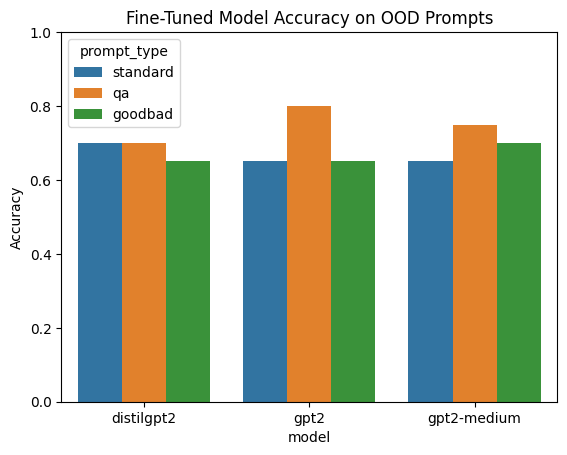

In [ ]:
# Experiment: OOD Prompt Robustness of Fine-Tuned Models
# This experiment tests how well fine-tuned GPT models (distilgpt2, gpt2, gpt2-medium) perform on out-of-distribution (OOD) prompt formats.

# Models are fine-tuned on the standard prompt format.

# At test time, we evaluate using:

# Standard: Review: ... Sentiment:

# QA-style: Question: What is the sentiment...? Answer:

# Good/Bad: Review: ... Label:

# The accuracy is measured on 20 test samples per prompt type. Results are visualized as a bar plot to show how robust each model is to prompt variation.


def format_ood_input(text, prompt_type="standard"):
    if prompt_type == "qa":
        return f'Question: What is the sentiment of the following review?\n"{text}"\nAnswer:'
    elif prompt_type == "goodbad":
        return f"Review: {text}\nLabel:"
    else:  # standard
        return f"Review: {text}\nSentiment:"


from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

def evaluate_finetuned_model(model_name_or_path, prompt_type="standard", num_samples=20):
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)
    model.eval()

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

    correct = 0
    subset = dataset["test"].select(range(num_samples))  # ✅ only first 20 samples

    for i, ex in enumerate(subset):
        text = format_ood_input(ex["text"][:300], prompt_type)
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=-1).item()

        # Optional: Uncomment to debug a few examples
        # print(f"\nPrompt: {prompt_type} | Sample #{i}")
        # print(f"Review: {ex['text'][:300]}")
        # print(f"Prediction: {'positive' if pred else 'negative'} | True: {'positive' if ex['label'] else 'negative'}")

        if pred == ex["label"]:
            correct += 1

    return correct / num_samples




models = {
    "distilgpt2": "distilgpt2-finetuned",
    "gpt2": "gpt2-finetuned",
    "gpt2-medium": "gpt2-medium-finetuned"
}

prompt_types = ["standard", "qa", "goodbad"]
results = []

for model_label, model_path in models.items():
    for prompt_type in prompt_types:
        print(f"\nRunning {prompt_type} evaluation for {model_label}...")
        acc = evaluate_finetuned_model(model_path, prompt_type, num_samples=20)
        results.append({
            "model": model_label,
            "prompt_type": prompt_type,
            "accuracy": acc
        })


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
print(df)

sns.barplot(data=df, x="model", y="accuracy", hue="prompt_type")
plt.title("Fine-Tuned Model Accuracy on OOD Prompts")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.show()



🔍 Processing distilgpt2...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(



🔍 Processing gpt2...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(



🔍 Processing gpt2-medium...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


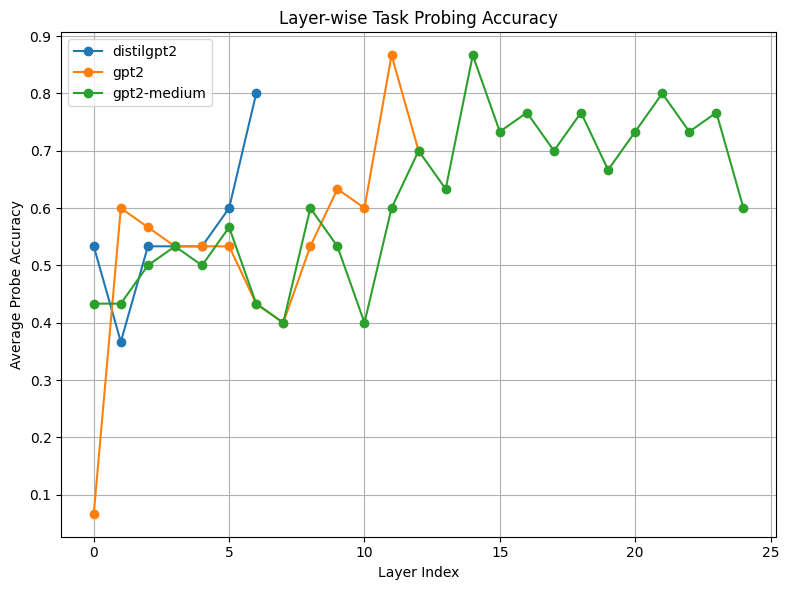

In [ ]:

# Experiment: Layer-wise Probing of GPT Models
# This experiment investigates how well different layers of GPT models (distilgpt2, gpt2, gpt2-medium) encode task-relevant information.

# Tasks: Sentiment, Addition, and QA.

# For each input, we extract the mean hidden state from every layer.

# A logistic regression probe is trained per layer to classify the task.

# Accuracy is averaged over 10 runs to ensure stability.

# The final plot shows how task information evolves across layers, revealing where in the network the most distinguishable representations emerge.






import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Define the models you want to compare
model_names = ["distilgpt2", "gpt2", "gpt2-medium"]

# Define task examples
task_data = {
    "sentiment": [
        "This movie was fantastic!",
        "I hated the service at the restaurant.",
        "The product exceeded my expectations.",
    ],
    "addition": [
        "What is 5 plus 3?",
        "Add 12 and 7.",
        "Calculate 34 + 9.",
    ],
    "qa": [
        "Who is the president of the United States?",
        "What is the capital of France?",
        "How many legs does a spider have?",
    ]
}
task_to_label = {task: i for i, task in enumerate(task_data)}

# Probe parameters
NUM_RUNS = 10
TEST_SIZE = 0.3

def get_layerwise_representations(text, tokenizer, model):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)
    return [layer.mean(dim=1).squeeze(0).numpy() for layer in outputs.hidden_states]

# Store accuracies for all models
model_layer_accuracies = {}

for model_name in model_names:
    print(f"\n🔍 Processing {model_name}...")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
    model.eval()

    layerwise_X = None
    y = []

    for task, examples in task_data.items():
        for ex in examples:
            reps = get_layerwise_representations(ex, tokenizer, model)
            if layerwise_X is None:
                layerwise_X = [[] for _ in range(len(reps))]
            for i, r in enumerate(reps):
                layerwise_X[i].append(r)
            y.append(task_to_label[task])

    y = np.array(y)
    layer_accuracies = []

    for layer_idx, layer_X in enumerate(layerwise_X):
        layer_X = np.stack(layer_X)
        accs = []
        for _ in range(NUM_RUNS):
            X_train, X_test, y_train, y_test = train_test_split(layer_X, y, test_size=TEST_SIZE)
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accs.append(accuracy_score(y_test, y_pred))
        avg_acc = np.mean(accs)
        layer_accuracies.append(avg_acc)

    model_layer_accuracies[model_name] = layer_accuracies

# Plotting
plt.figure(figsize=(8, 6))
for model_name, accs in model_layer_accuracies.items():
    plt.plot(range(len(accs)), accs, marker='o', label=model_name)

plt.xlabel("Layer Index")
plt.ylabel("Average Probe Accuracy")
plt.title("Layer-wise Task Probing Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
